<a href="https://colab.research.google.com/github/swiminthewind/colab/blob/main/230731-%E5%BE%97%E5%88%B0no_clouds_tiles%E5%92%8Cclouds_tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks1/")

# Import libraries

In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from osgeo import gdal
import skimage
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras.backend as K

from skimage.transform import resize
from keras import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Lambda, Dropout, BatchNormalization, Add, Concatenate
from keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from keras.layers import  Activation, Reshape, Dense, Flatten, ZeroPadding2D
from keras.models import save_model, load_model
from keras.initializers import RandomNormal

Instructions for updating:
non-resource variables are not supported in the long term


# Load the images

In [4]:
def read_tiff(tiff_file):
    data = gdal.Open(tiff_file).ReadAsArray()
    return data

def load_sentinel_data(path):
    img_paths = sorted(glob.glob(path + '*.tif'))
    image = [np.expand_dims(read_tiff(img).astype('float32'), -1) for img in img_paths]
    image = np.concatenate(image, axis=-1)
    print("Image shape: ", image.shape, " Min value: ", image.min(), " Max value: ", image.max())
    return image

In [5]:
S2_img = load_sentinel_data('data/20210802_S2A_10m/')
S1_img = load_sentinel_data('data/20210802_S1A_10m/')

Image shape:  (4193, 6774, 5)  Min value:  nan  Max value:  nan
Image shape:  (4193, 6774, 2)  Min value:  -49.711483  Max value:  30.08639


In [6]:
S2_QA = load_sentinel_data('QA/20210802_S2A_10m/')

Image shape:  (4193, 6774, 1)  Min value:  0.0  Max value:  1024.0


# Split image into training, validation and testing tiles

In [7]:
def create_idx_image(rows, cols):
    im_idx = np.arange(rows * cols).reshape(rows, cols)
    return im_idx

def extract_patches(im_idx, patch_size, overlap):
    '''overlap range: 0 - 1 '''
    row_steps, cols_steps = int((1-overlap) * patch_size[0]), int((1-overlap) * patch_size[1])
    patches = skimage.util.view_as_windows(im_idx, patch_size, step=(row_steps, cols_steps))
    return patches

In [8]:
rows, cols = S2_img.shape[:2]
print(rows, cols)
im_idx = create_idx_image(rows, cols)

patches_idx = extract_patches(im_idx, patch_size=(256, 256), overlap=0).reshape(-1, 256, 256)

4193 6774


In [9]:
patches_idx.shape

(416, 256, 256)

# Preprocessing Images

In [10]:
def filter_outliers(img, bins=1000000, bth=0.03, uth=0.97, mask=[0]):
    img[np.isnan(img)]=0 # Filter NaN values.
    if len(mask)==1:
        mask = np.zeros((img.shape[:2]), dtype='int64')
    for band in range(img.shape[-1]):
        hist = np.histogram(img[:mask.shape[0], :mask.shape[1]][mask!=2, band].ravel(),bins=bins) # select not testing pixels
        cum_hist = np.cumsum(hist[0])/hist[0].sum()
        max_value = np.ceil(100*hist[1][len(cum_hist[cum_hist<uth])])/100
        min_value = np.ceil(100*hist[1][len(cum_hist[cum_hist<bth])])/100
        img[:,:, band][img[:,:, band]>max_value] = max_value
        img[:,:, band][img[:,:, band]<min_value] = min_value
    return img

def normalize(img):
    '''image shape: [row, cols, channels]'''
    img = 2*(img -img.min(axis=(0,1), keepdims=True))/(img.max(axis=(0,1), keepdims=True) - img.min(axis=(0,1), keepdims=True)) - 1
    return img

In [11]:
S2_img = filter_outliers(S2_img.copy(), bins=int(2**16/2))

In [12]:
S2_img = normalize(S2_img)

In [13]:
S2_img.min(), S2_img.max()

(-1.0, 1.0)

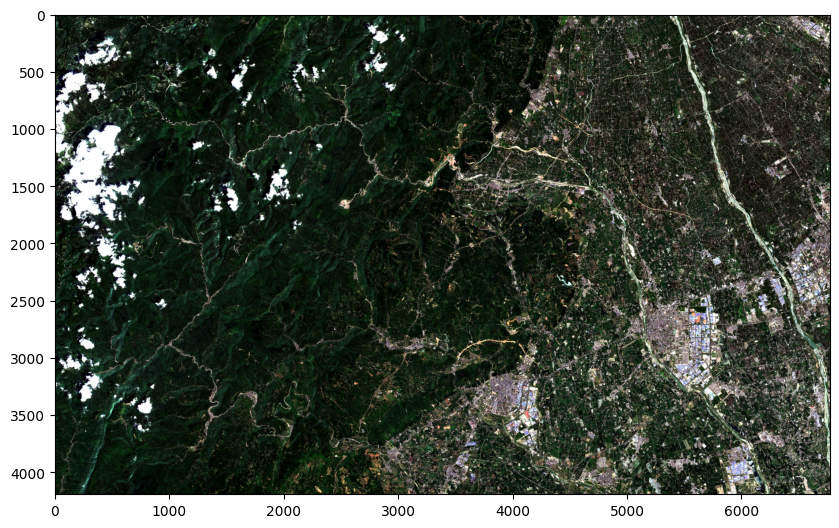

In [14]:
plt.figure(figsize=(10,10))
plt.imshow((S2_img[:,:,[2,1,0]] + 1)/2)
plt.show()
plt.close()

# 切片

In [15]:
c_dim_opt = S2_img.shape[-1]
S2_img_1 = S2_img.reshape(-1, c_dim_opt)[patches_idx[0]]

In [16]:
print(S2_img_1.shape)

(256, 256, 5)


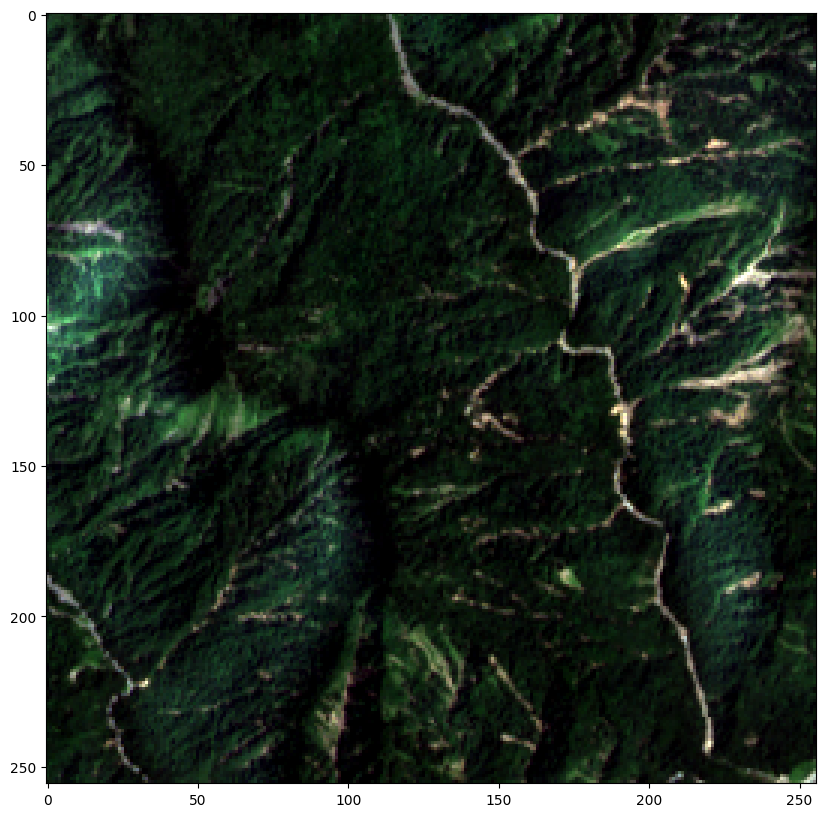

In [17]:
plt.figure(figsize=(10,10))
plt.imshow((S2_img_1[:,:,[2,1,0]] + 1)/2)
plt.show()
plt.close()

# 查看云量

In [18]:
c_dim_QA = S2_QA.shape[-1]

In [19]:
S2_QA_1 = S2_QA.reshape(-1, c_dim_QA)[patches_idx[0]]

In [20]:
S2_QA_1.shape

(256, 256, 1)

In [21]:
def check_values_in_array(arr):
    flat_arr = arr.flatten()
    if 1024 in flat_arr or 2048 in flat_arr:
        return True
    else:
        return False

In [24]:
no_clouds_tiles = []
clouds_tiles = []
for i in range(len(patches_idx)):
    if check_values_in_array(S2_QA.reshape(-1, c_dim_QA)[patches_idx[i]]) == False:
        no_clouds_tiles.append(i)
    else:
        clouds_tiles.append(i)

In [25]:
print(clouds_tiles)

[26, 27, 52, 53, 58, 78, 79, 80, 104, 105, 106, 130, 131, 137, 156, 157, 158, 182, 183, 209, 286, 287, 312, 313, 338, 339, 340, 341]
